# Attaque sur un algorithme $\epsilon$-greedy

Dans ce notebook, je reproduis et j'étends certaines des simulations évoquées dans l'article "Adversarial Attacks on Stochastic Bandits" by Kwang-Sung Jun, Lihong Li, Yuzhe Ma, Jerry Zhu. 

# Pré-requis

- fonction de génération du dataset
- fonctions d'évaluation du regret immédiat et du regret total

In [3]:
# packages nécessaires
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import bernoulli
from numpy.random import choice
import math
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
# fonction pour générer un dataset
def generate_dataset(nb_rounds, mean_vals,sigma):
    rounds_data=[]
    for my_round in range(nb_rounds):
        # on simule une loi normale en fonction des paramètres mean_vals
        round_vector=[np.random.normal(loc=mean,scale=sigma) for mean in mean_vals]
        rounds_data.append(round_vector)
    final_df=np.array(rounds_data)
    cols=["Arm_"+str(i+1) for i in range(len(mean_vals))]
    final_df=pd.DataFrame(final_df,columns=cols)
    return final_df

In [5]:
# test de la fonction permettant de générer un dataset
mean_vals=[2,0]
sigma=0.1
generate_dataset(100,mean_vals,sigma).head()

,Arm_1,Arm_2
0,1.872220,-0.151156
1,2.108468,-0.131410
2,1.837003,-0.161586
3,2.071396,-0.136201
4,1.919109,0.067574


In [48]:
# regret immédiat
def compute_imm_regrets(rewards,true_means):
    max_mean=np.max(true_means)
    nb_rounds=len(rewards)
    imm_regrets=[]
    for i in range(nb_rounds):
        current_emp_mean=np.mean(rewards[:i+1])
        imm_regret=(max_mean-current_emp_mean)
        imm_regrets.append(imm_regret)
    return(imm_regrets)

# regret total
def compute_regret(rewards,true_means):
    n_rounds=len(rewards)
    # on regarde la moyenne théorique du meilleur bras
    max_arm_means=np.max(true_means)
    # on compare avec la séquence qu'on a fait nous
    regret=np.sum(max_arm_means-rewards)
    return(regret)

# Simulations

- Le bandit a deux bras avec $\mu_1=\Delta_1>0$ et $\mu_2=0$
- Alice cible le deuxième bras (bras sous-optimal)
- Dans le scénario par défaut on fixera $\delta=0.025$, $\sigma=0.1$ et $\epsilon_t=\frac{1}{t}$ $\forall t$

## Fonctions de base

On commence par définir deux fonctions annexes : epsilon_strat (permet de définir la stratégie d'exploration choisie par Bob) et beta_function (qui calcule la valeur de $\beta(N)$)

In [7]:
def epsilon_strat(t):
    return(1/t)

In [8]:
def beta_function(N,sigma,delta,K):
    result=(math.pi**2)*K*(N**2)
    result/=3*delta
    result=np.log(result)
    result*=2*(sigma**2)/N
    result=result**0.5
    return(result)

On peut désormais définir notre algorithme epsilon_greedy avec et sans attaques. 

In [9]:
def epsilon_greedy(dataset,with_attack=False,epsilon=epsilon_strat,tqdm_bool=False):
    #nombre de bras
    nb_arms=dataset.shape[1]
    # notre bras cible est toujours le dernier bras
    target_arm=nb_arms-1
    
    # nombre de tours
    nb_rounds=dataset.shape[0]
    
    # initialisation des vecteurs
    selected_arms=[] #bras sélectionnés
    true_rewards=[] # rewards avant attaques
    attacked_rewards=[] # rewards après attaques
    attack_costs=[] #coût de chaque attaque
    true_rewards_per_arm={arm: 0 for arm in range(nb_arms)}
    
    # on lance les rounds
    for i in tqdm(range(nb_rounds),disable=tqdm_bool):
    # on commence par jouer chaque bras une fois en commencant par le dernier
        if i<nb_arms:
            selected_arm=(nb_arms-i-1)
    # après ce premier passage Bob alterne entre exploration/exploitation 
        else:
            # on stocke dans un dataframe les rewards et les bras sélectionnés
            rewards_df=pd.DataFrame({'Selected_Arm':selected_arms,'Attacked_Reward':attacked_rewards,'True_Reward':true_rewards})

            # Bob cherche le meilleur bras
            attacked_rewards_per_arm=rewards_df.groupby('Selected_Arm')['Attacked_Reward'].mean()
            best_arm=attacked_rewards_per_arm.idxmax(axis=1)
            
            # Seule Alice a connaissance des vraies moyennes empiriques
            true_rewards_per_arm=rewards_df.groupby('Selected_Arm')['True_Reward'].mean()
            
            # on tire une bernouilli en fonction du paramètre epsilon=1/t
            my_epsilon=epsilon(i)
            ber=bernoulli.rvs(my_epsilon)
            if ber==1: #j'explore aléatoirement
                selected_arm=choice([arm for arm in range(nb_arms)])
            else: # je choisis le meilleur bras
                selected_arm=best_arm
            
        # rewards observées par Alice
        true_reward=dataset[i,selected_arm]
        true_rewards.append(true_reward)
        
        # attaque ou pas d'attaque?
        attack=0
        if with_attack==True:
            # on attaque uniquement les bras non ciblés
            if selected_arm!=target_arm:
                # paramètres de l'attaque
                n_It_prec=selected_arms.count(selected_arm)
                n_K=selected_arms.count(target_arm)
                mu_It_prec=true_rewards_per_arm[selected_arm]
                mu_k=true_rewards_per_arm[target_arm]
                beta_nk=beta_function(n_K,sigma,delta,nb_arms)
                # définition de l'attaque
                attack=max(0,mu_It_prec*n_It_prec+true_reward-(mu_k-2*beta_nk)*(n_It_prec+1))                    
        # Bob obtient sa reward (reward - attaque)
        attacked_reward=dataset[i,selected_arm]-attack
        # on sauvegarde le coût de l'attaque
        attack_costs.append(attack)
        attacked_rewards.append(attacked_reward)
        selected_arms.append(selected_arm)
    return(attacked_rewards,selected_arms,attack_costs)

## Première simulation

Dans un premier temps on s'intéresse au cas $\Delta_1=2$

In [10]:
mean_vals=[2,0]
# paramètres d'initialisation
n_rounds=10000
sigma=0.1
delta=0.025
nb_arms=len(mean_vals)
dataset=generate_dataset(n_rounds,mean_vals,sigma)

In [11]:
# on calcule les rewards sans attaque
rewards_no_attack,sel_arms_no_attack,costs=epsilon_greedy(dataset.values,with_attack=False)
# on calcule les rewards avec attaque
rewards_attack,sel_arms_attack,attack_costs=epsilon_greedy(dataset.values,with_attack=True)

100%|██████████| 10000/10000 [00:36<00:00, 273.10it/s]


On regarde le nombre de fois que le bras cible a été tiré dans le scénario avec attaque et dans le scénario sans attaque.

Sans attaque le bras cible est joué au total 4 fois
Avec attaque le bras cible est joué au total 9998 fois


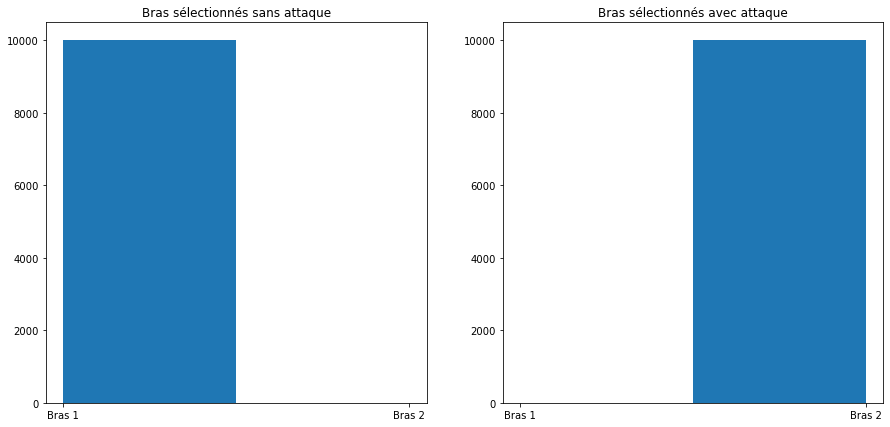

In [12]:
print('Sans attaque le bras cible est joué au total '+str(sel_arms_no_attack.count(1))+' fois')
print('Avec attaque le bras cible est joué au total '+str(sel_arms_attack.count(1))+' fois')

fig=plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(sel_arms_no_attack,bins=nb_arms)
plt.title('Bras sélectionnés sans attaque')
plt.xticks(np.arange(2), ('Bras 1', 'Bras 2'))
plt.subplot(122)
plt.hist(sel_arms_attack,bins=nb_arms)
plt.title('Bras sélectionnés avec attaque')
plt.xticks(np.arange(2), ('Bras 1', 'Bras 2'))
plt.show()

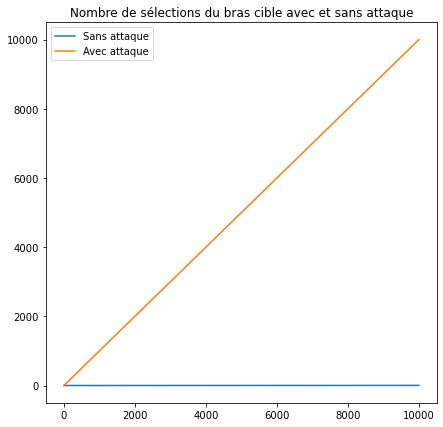

In [13]:
# tirage du bras cible (NK(t))
fig=plt.figure(figsize=(7,7))
plt.plot(np.cumsum((np.asarray(sel_arms_no_attack)==1)*1),label='Sans attaque')
plt.plot(np.cumsum((np.asarray(sel_arms_attack)==1)*1),label='Avec attaque')
plt.title('Nombre de sélections du bras cible avec et sans attaque')
plt.legend()
plt.show()

On s'intéresse à l'impact sur le regret de Bob. 

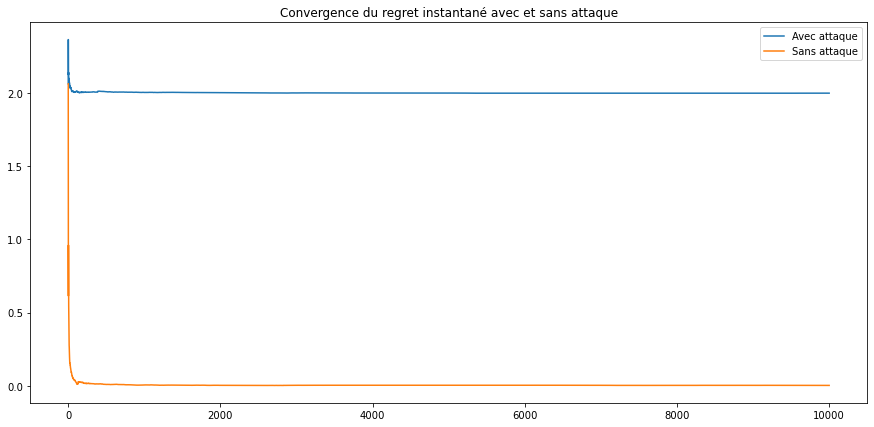

In [14]:
# graph des regrets immédiats
fig=plt.figure(figsize=(15,7))
plt.plot(compute_imm_regrets(rewards_attack,mean_vals),label='Avec attaque')
plt.plot(compute_imm_regrets(rewards_no_attack,mean_vals),label='Sans attaque')
plt.title('Convergence du regret instantané avec et sans attaque')
plt.legend()
plt.show()

On s'intéresse au coût cumulé de l'attaque pour Alice. 

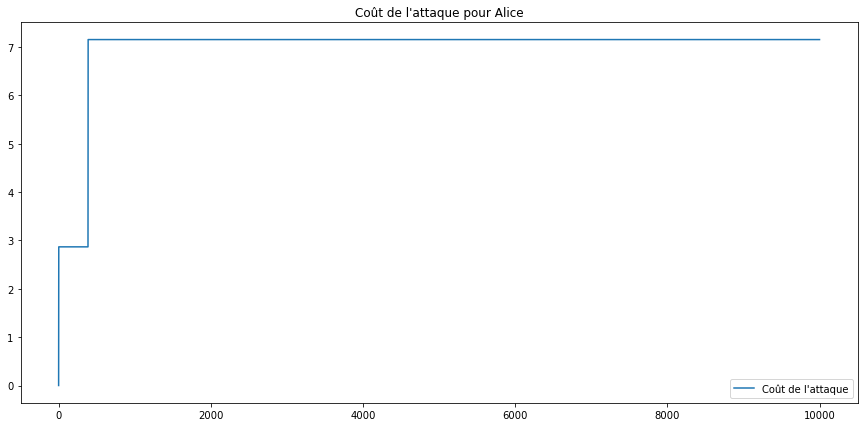

In [15]:
fig=plt.figure(figsize=(15,7))
plt.plot(np.cumsum(attack_costs),label='Coût de l\'attaque')
plt.title('Coût de l\'attaque pour Alice')
plt.legend()
plt.show()

## Impact de la valeur de $\Delta_1$

On va maintenant s'intéresser à l'influence de $\Delta_1$ sur le coût de l'algorithme pour Alice. Pour ce faire on va effectuer 100 simulations (1000 tours par simulations) pour 3 valeurs de delta : 1,2 et 5 et tracer les courbes moyennes de coûts d'attaque. 

In [54]:
delta_vals=[1,2,5]
n_rounds=1000
sigma=0.1
delta=0.025
n=100

final_dict={my_delta:[] for my_delta in delta_vals}

for my_delta in delta_vals:
    mean_vals=[my_delta,0]
    for i in range(n):
        dataset=generate_dataset(n_rounds,mean_vals,sigma)
        rewards_attack,sel_arms_attack,attack_costs=epsilon_greedy(dataset.values,with_attack=True,tqdm_bool=True)
        if i==0:
            final_dict[my_delta]=np.asarray(attack_costs)
        else:
            final_dict[my_delta]+=np.asarray(attack_costs)
    final_dict[my_delta]/=n
    final_dict[my_delta]=np.cumsum(final_dict[my_delta])

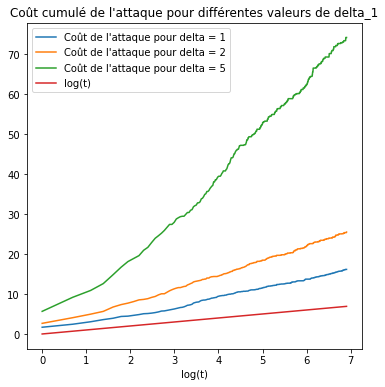

In [58]:
# Coût de l'attaque en fonction de delta_1
fig=plt.figure(figsize=(6,6))

for my_delta in delta_vals:
    plt.plot(np.log(range(n_rounds)),final_dict[my_delta],label='Coût de l\'attaque pour delta = '+str(my_delta))
plt.plot(np.log(range(n_rounds)),np.log(range(n_rounds)),label='log(t)')
plt.title('Coût cumulé de l\'attaque pour différentes valeurs de delta_1')
plt.xlabel('log(t)')
plt.legend()
plt.show()

## Impact de la valeur de $\sigma$

On va maintenant s'intéresser à l'influence de $\sigma$ sur le coût de l'algorithme pour Alice. Pour ce faire on va effectuer 100 simulations (1000 tours par simulations) pour 3 valeurs de delta : 0.1,0.2 et 0.5 et tracer les courbes moyennes de coûts d'attaque. 

In [61]:
sigma_vals=[0.1,0.2,0.5]
n_rounds=1000
delta=0.025
n=100

sigma_dict={sigma:[] for sigma in sigma_vals}

for sigma in sigma_vals:
    mean_vals=[2,0]
    for i in range(n):
        dataset=generate_dataset(n_rounds,mean_vals,sigma)
        rewards_attack,sel_arms_attack,attack_costs=epsilon_greedy(dataset.values,with_attack=True,tqdm_bool=True)
        if i==0:
            sigma_dict[sigma]=np.asarray(attack_costs)
        else:
            sigma_dict[sigma]+=np.asarray(attack_costs)
    sigma_dict[sigma]/=n
    sigma_dict[sigma]=np.cumsum(sigma_dict[sigma])

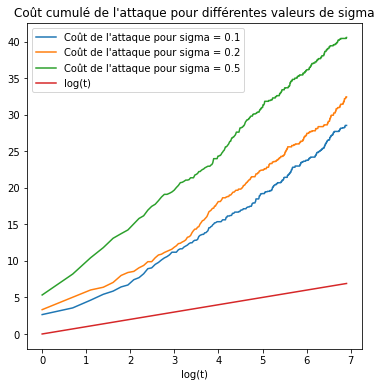

In [63]:
# Coût de l'attaque en fonction de sigma
fig=plt.figure(figsize=(6,6))

for sigma in sigma_vals:
    plt.plot(np.log(range(n_rounds)),sigma_dict[sigma],label='Coût de l\'attaque pour sigma = '+str(sigma))
plt.title('Coût cumulé de l\'attaque pour différentes valeurs de sigma')
plt.plot(np.log(range(n_rounds)),np.log(range(n_rounds)),label='log(t)')
plt.xlabel('log(t)')
plt.legend()
plt.show()

## Stratégie plus exploratrice de la part de Bob

On s'intéresse à la façon dont Bob pourrait mettre Alice en difficulté. Pour ce faire on va comparer l'implémentation déjà évoquée d'$\epsilon$-greedy avec une approche plus exploratoire ($\epsilon$ est fixé à 0.3 tout au long du jeu). 

In [18]:
def epsilon_alt_strat(t):
    return(0.3)

In [64]:
mean_vals=[2,0]
# paramètres d'initialisation
n_rounds=10000
sigma=0.1
delta=0.025
nb_arms=len(mean_vals)
dataset=generate_dataset(n_rounds,mean_vals,sigma)

In [65]:
# on calcule les rewards sans attaque
rewards_no_attack,sel_arms_no_attack,costs=epsilon_greedy(dataset.values,with_attack=False)
# on calcule les rewards avec attaque et stratégie epsilon de base
rewards_attack,sel_arms_attack,attack_costs=epsilon_greedy(dataset.values,with_attack=True)
# on calcule les rewards avec attaque et stratégie epsilon plus prudente
rewards_attack_pru,sel_arms_attack_pru,attack_costs_pru=epsilon_greedy(dataset.values,epsilon=epsilon_alt_strat,with_attack=True)

100%|██████████| 10000/10000 [00:41<00:00, 241.69it/s]


Sans attaque le bras cible est joué au total 5 fois
Avec attaque le bras cible est joué au total 9993 fois
Avec attaque sur une stratégie plus prudente le bras cible est joué au total 8539 fois


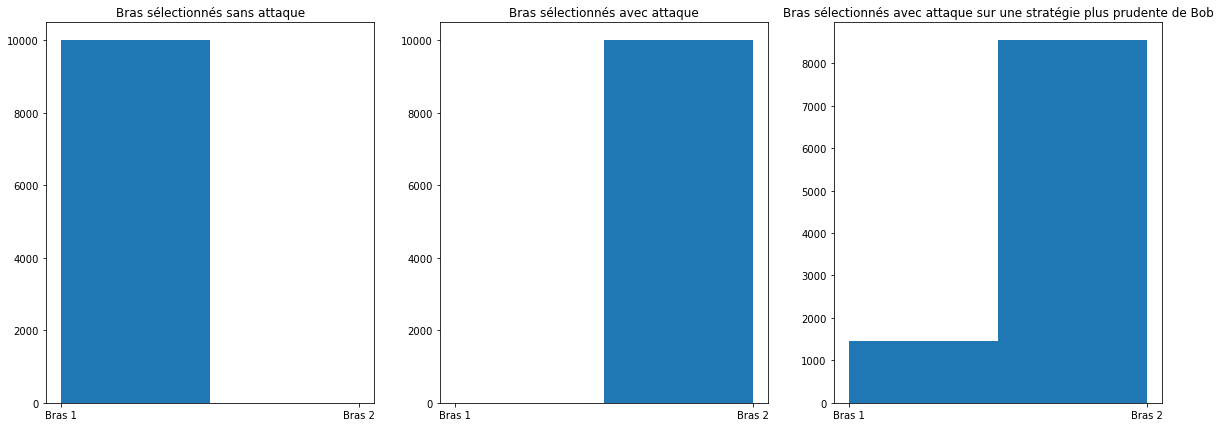

In [66]:
print('Sans attaque le bras cible est joué au total '+str(sel_arms_no_attack.count(1))+' fois')
print('Avec attaque le bras cible est joué au total '+str(sel_arms_attack.count(1))+' fois')
print('Avec attaque sur une stratégie plus prudente le bras cible est joué au total '+str(sel_arms_attack_pru.count(1))+' fois')

fig=plt.figure(figsize=(20,7))
plt.subplot(131)
plt.hist(sel_arms_no_attack,bins=nb_arms)
plt.title('Bras sélectionnés sans attaque')
plt.xticks(np.arange(2), ('Bras 1', 'Bras 2'))
plt.subplot(132)
plt.hist(sel_arms_attack,bins=nb_arms)
plt.xticks(np.arange(2), ('Bras 1', 'Bras 2'))
plt.title('Bras sélectionnés avec attaque')
plt.subplot(133)
plt.hist(sel_arms_attack_pru,bins=nb_arms)
plt.xticks(np.arange(2), ('Bras 1', 'Bras 2'))
plt.title('Bras sélectionnés avec attaque sur une stratégie plus prudente de Bob')
plt.show()

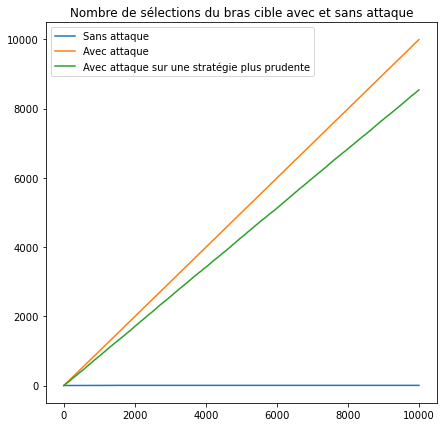

In [71]:
# tirage du bras cible (NK(t))
fig=plt.figure(figsize=(7,7))
plt.plot(np.cumsum((np.asarray(sel_arms_no_attack)==1)*1),label='Sans attaque')
plt.plot(np.cumsum((np.asarray(sel_arms_attack)==1)*1),label='Avec attaque')
plt.plot(np.cumsum((np.asarray(sel_arms_attack_pru)==1)*1),label='Avec attaque sur une stratégie plus prudente')

plt.title('Nombre de sélections du bras cible avec et sans attaque')
plt.legend()
plt.show()

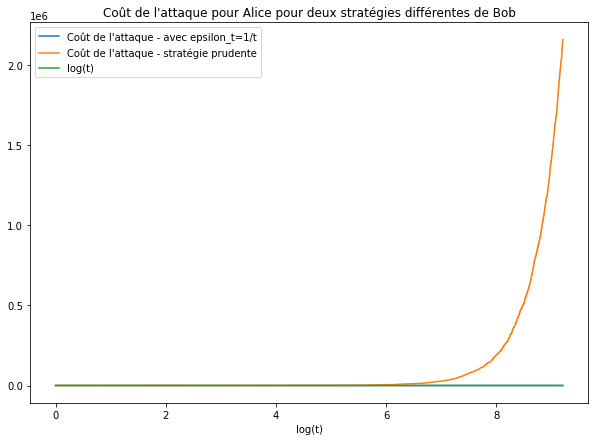

Avec attaque sur l'algorithme de base le coût de l'attaque pour Alice est de  61.96894116489848
Avec attaque sur l'algorithme plus prudent le coût de l'attaque pour Alice est de  2159003.008801297
Le coût est donc multiplié par 34840


In [78]:
fig=plt.figure(figsize=(10,7))

plt.plot(np.log(range(n_rounds)),np.cumsum(attack_costs),label='Coût de l\'attaque - avec epsilon_t=1/t')
plt.plot(np.log(range(n_rounds)),np.cumsum(attack_costs_pru),label='Coût de l\'attaque - stratégie prudente')
plt.title('Coût de l\'attaque pour Alice pour deux stratégies différentes de Bob')
plt.plot(np.log(range(n_rounds)),np.log(range(n_rounds)),label='log(t)')
plt.xlabel('log(t)')
plt.legend()
plt.show()

print('Avec attaque sur l\'algorithme de base le coût de l\'attaque pour Alice est de  '+str(np.sum(attack_costs)))
print('Avec attaque sur l\'algorithme plus prudent le coût de l\'attaque pour Alice est de  '+str(np.sum(attack_costs_pru)))
print('Le coût est donc multiplié par '+str(round(np.sum(attack_costs_pru)/np.sum(attack_costs),)))

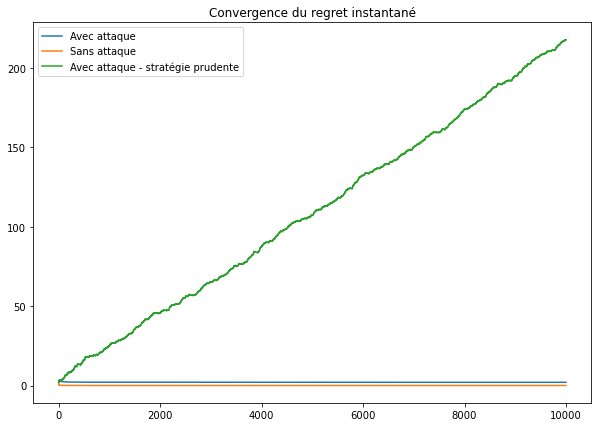

Avec attaque sur l'algorithme de base le regret est de 20060
Avec attaque sur l'algorithme plus prudent le regret est de  2176086
Le regret est donc multiplié par 108


In [79]:
# graph des regrets immédiats
fig=plt.figure(figsize=(10,7))
plt.plot(compute_imm_regrets(rewards_attack,mean_vals),label='Avec attaque')
plt.plot(compute_imm_regrets(rewards_no_attack,mean_vals),label='Sans attaque')
plt.plot(compute_imm_regrets(rewards_attack_pru,mean_vals),label='Avec attaque - stratégie prudente')
plt.title('Convergence du regret instantané')

plt.legend()
plt.show()

# regret total
print('Avec attaque sur l\'algorithme de base le regret est de '+str(round(compute_regret(rewards_attack,mean_vals))))
print('Avec attaque sur l\'algorithme plus prudent le regret est de  '+str(round(compute_regret(rewards_attack_pru,mean_vals))))
print('Le regret est donc multiplié par '+str(round(compute_regret(rewards_attack_pru,mean_vals)/compute_regret(rewards_attack,mean_vals))))
                                             